In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats 
import pymc as pm
import pymc.sampling_jax
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

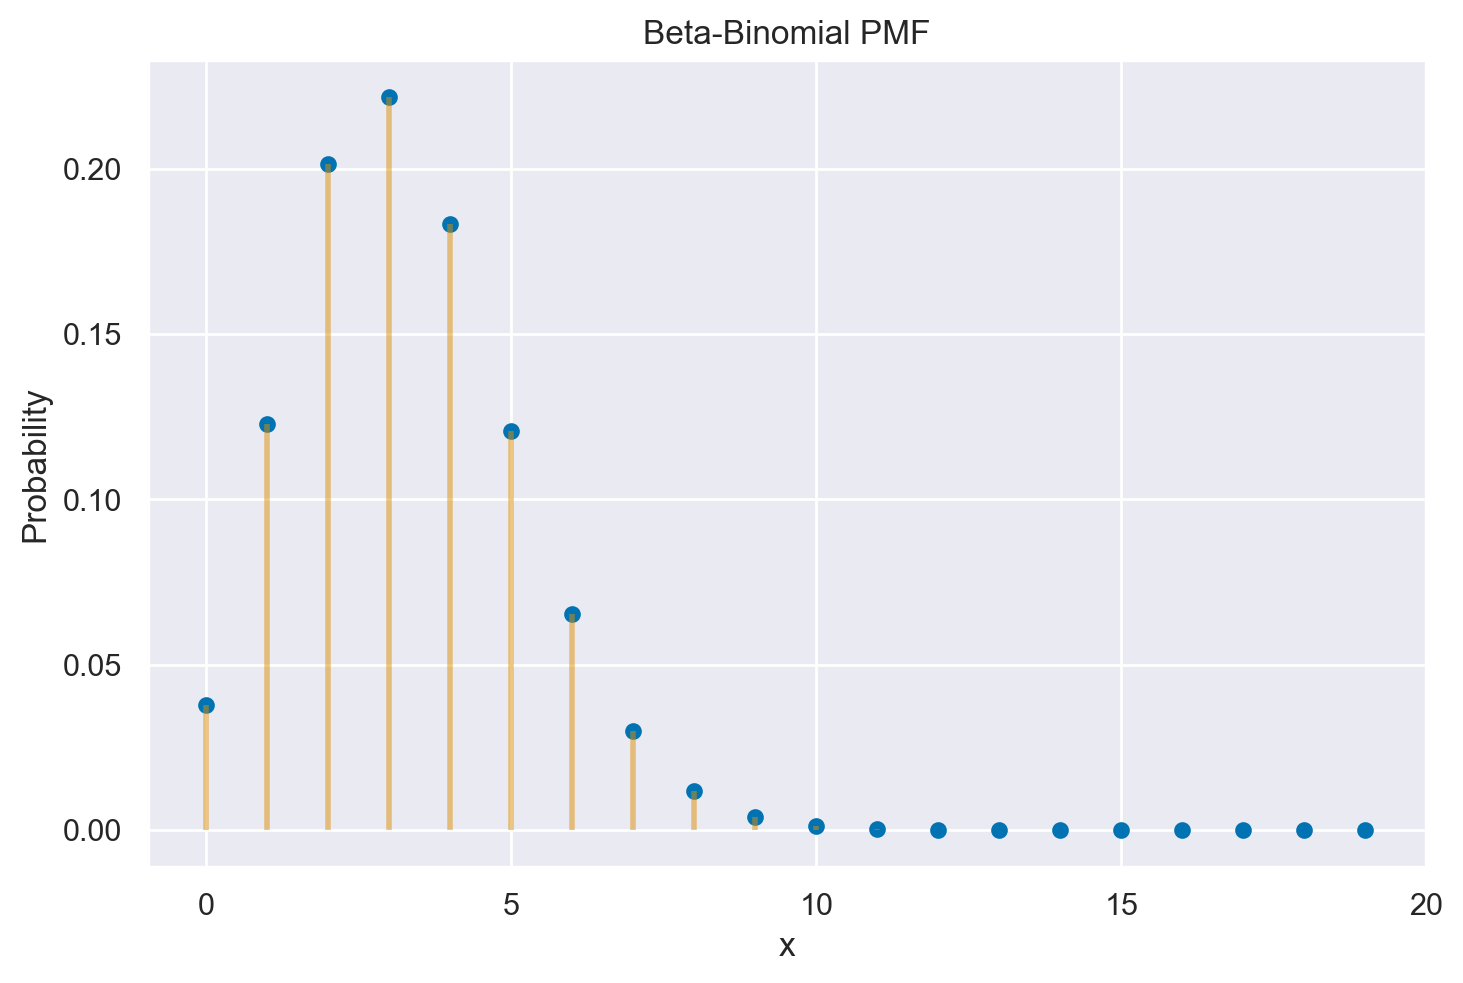

In [3]:
alpha = 4
beta = 6
y = 14
n = 100
alpha_prime = alpha + y
beta_prime = beta + n - y
m = 20
x = np.arange(0, 20)

plt.plot(
    x,
    stats.betabinom.pmf(x, m, alpha_prime, beta_prime),
    "C0o",
    ms=5,
    label="betabinom pmf",
)
_ = plt.vlines(
    x,
    0,
    stats.betabinom.pmf(x, m, alpha_prime, beta_prime),
    colors="C1",
    lw=2,
    alpha=0.5,
)

# Set x-ticks to be every 5 units
plt.xticks(np.arange(0, 21, 5))

plt.xlabel("x")
plt.ylabel("Probability")
_ = plt.title("Beta-Binomial PMF")

In [4]:
1 - stats.betabinom.cdf(4, m, alpha_prime, beta_prime).sum()

0.23298739435887628

In [5]:
x = np.arange(0, 21)
px = stats.betabinom.pmf(np.arange(0, 21), m, alpha_prime, beta_prime)

ev = sum(x * px)
print(ev)

3.272727272727284


In [6]:
nrep = 100000
theta = stats.beta.rvs(alpha_prime, beta_prime, size=nrep)
print(*theta[0:10])

0.1876466712617734 0.14123655133040988 0.09937032001331003 0.16564151313455117 0.2237071151882042 0.13647177755716866 0.16296610647400755 0.147306876911047 0.13423480535179516 0.11815022376184366


In [7]:
y_tilde = [stats.binom.rvs(n=20, p=th, size=1) for th in theta]
y_tilde = np.concatenate(y_tilde)
print(*y_tilde[0:50])

2 5 2 4 4 3 4 3 3 3 6 3 5 1 1 7 3 1 5 2 5 4 3 5 3 8 10 1 6 3 5 6 4 7 3 2 2 3 5 3 1 6 1 3 4 3 7 2 3 2


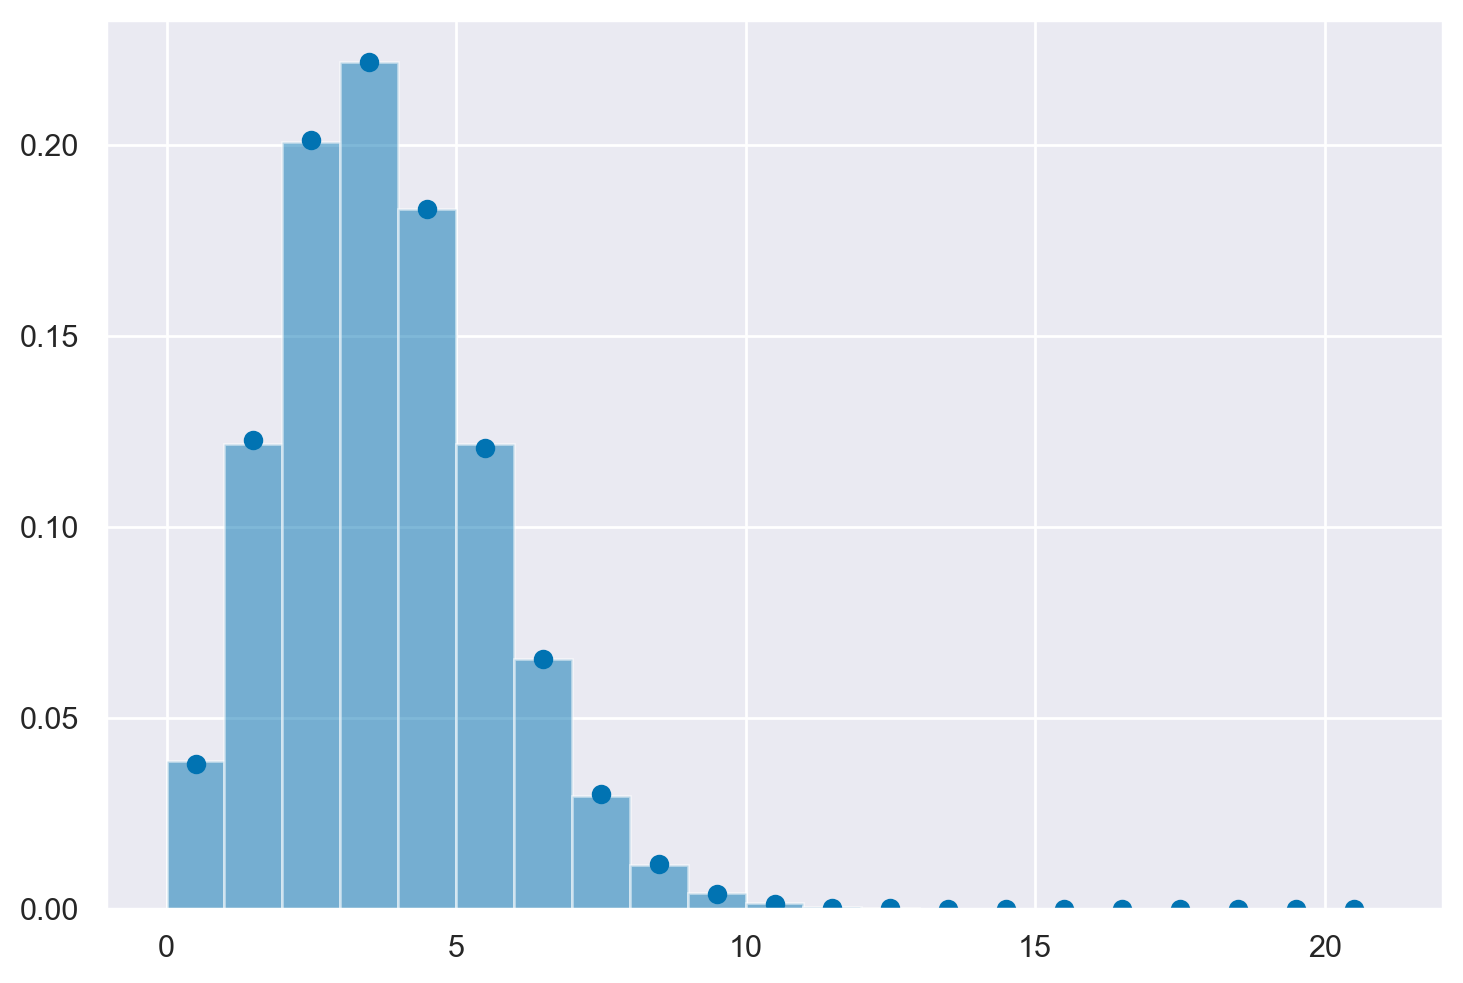

In [8]:
hist, bins, _ = plt.hist(y_tilde, bins=range(0, 22), density=True, alpha=0.5)
bin_centers = (bins[:-1] + bins[1:]) / 2
px = stats.betabinom.pmf(np.arange(0, 21), m, alpha_prime, beta_prime)
plt.plot(bin_centers, px, "o", color="C0", label="Beta-Binomial");

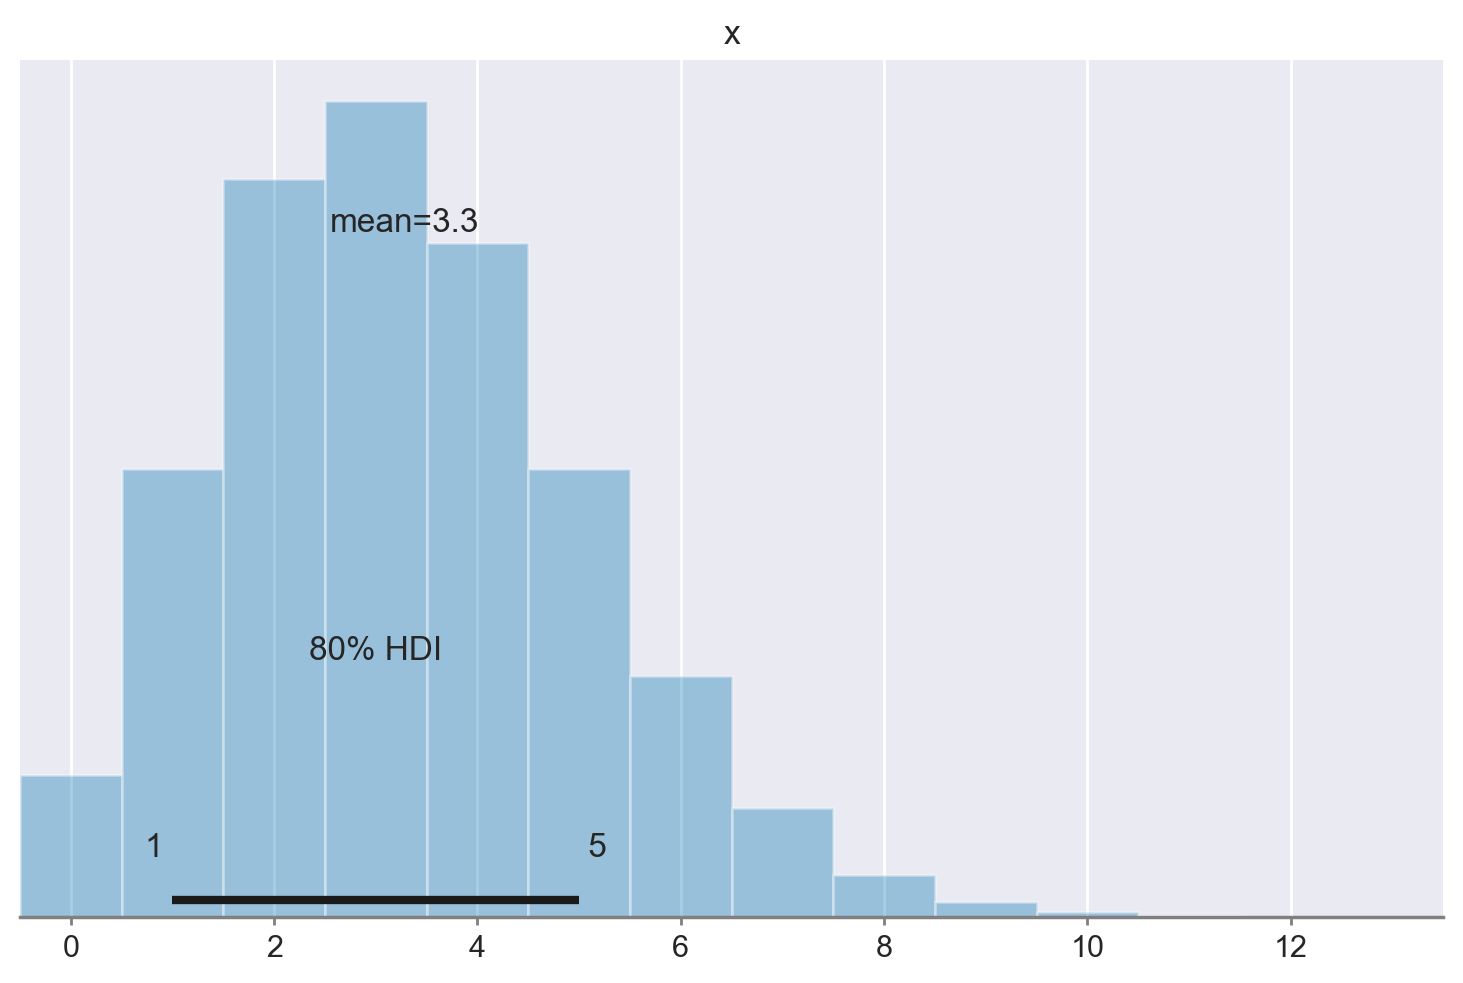

In [9]:
az.plot_posterior(y_tilde, hdi_prob=0.8, kind="kde", bw=0.5);

In [10]:
ntrials = 100
y = 14

alpha_prior = 4
beta_prior = 6

with pm.Model() as model:
    theta = pm.Beta("theta", alpha=alpha_prior, beta=beta_prior)
    obs = pm.Binomial("obs", p=theta, n=ntrials, observed=y)

In [11]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time = 0:00:09.306001


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1131.58it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1132.36it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1133.58it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1134.74it/s]


Sampling time = 0:00:02.691235


Transforming variables...


Transformation time = 0:00:00.090847


In [12]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.164,0.035,0.103,0.234,0.001,0.001,1338.0,1608.0,1.0


In [13]:
with model:
    post_pred = pm.sample_posterior_predictive(idata)

Sampling: [obs]


In [14]:
post_pred.posterior_predictive.obs

<xarray.DataArray 'obs' (chain: 4, draw: 1000)>
array([[15, 17, 23, ..., 12, 13, 13],
       [15, 12, 17, ..., 10, 17, 20],
       [15, 19, 12, ..., 14, 13, 19],
       [17,  6, 18, ...,  8, 15, 22]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

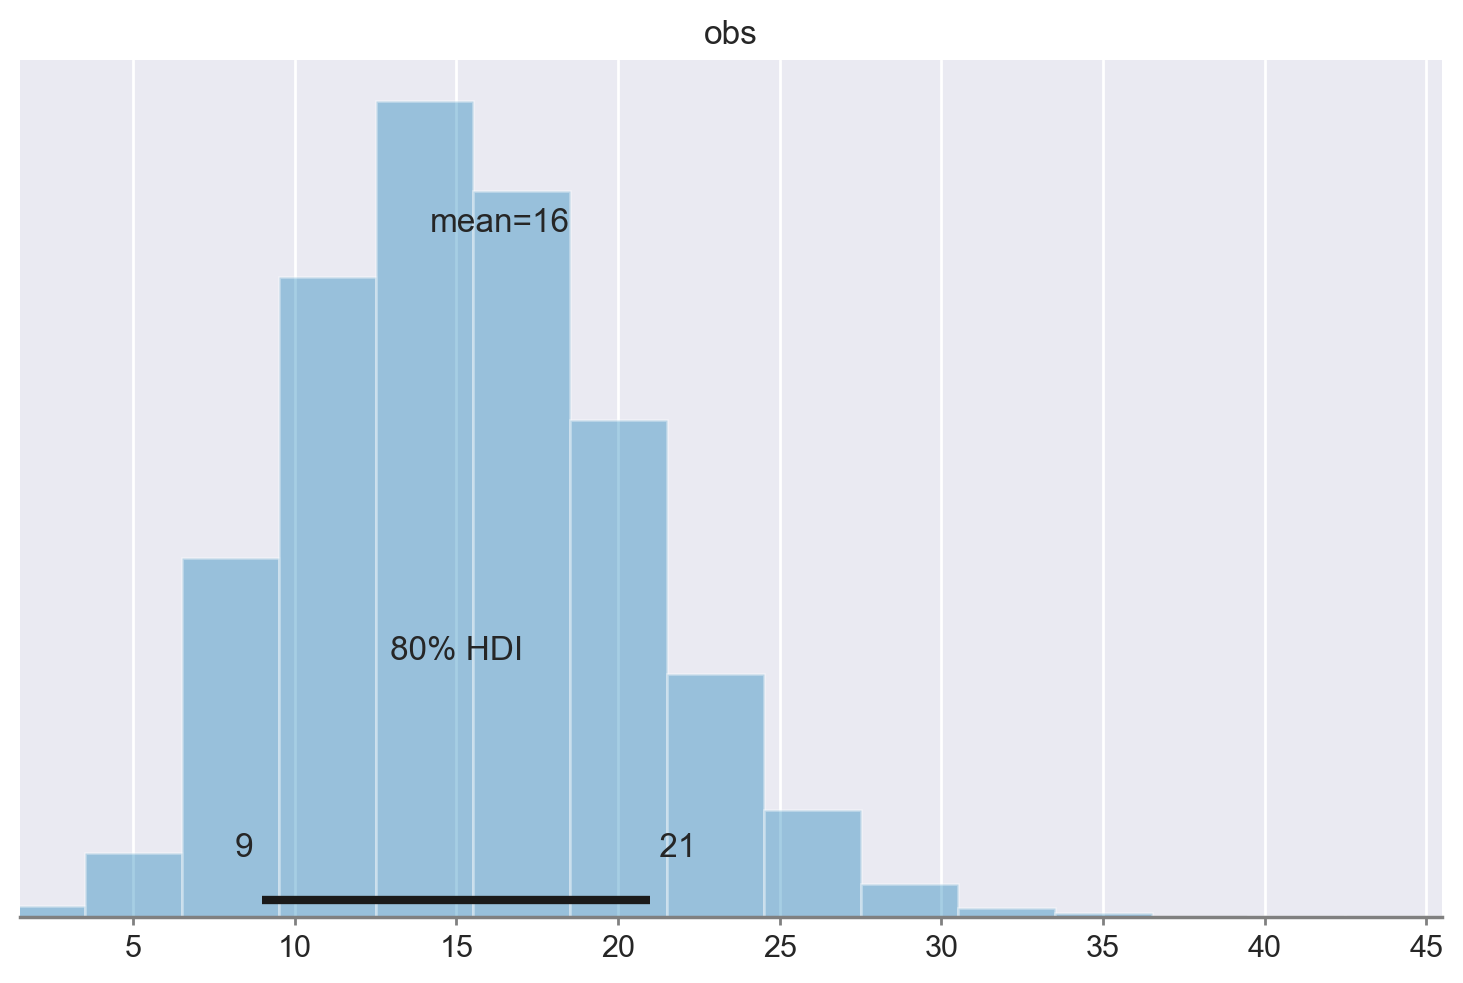

In [15]:
az.plot_posterior(post_pred.posterior_predictive.obs, hdi_prob=0.8)
plt.show()

In [16]:
post = az.extract(idata)
post["theta"].size

4000

In [17]:
y_rep = stats.binom.rvs(n=20, p=post["theta"])

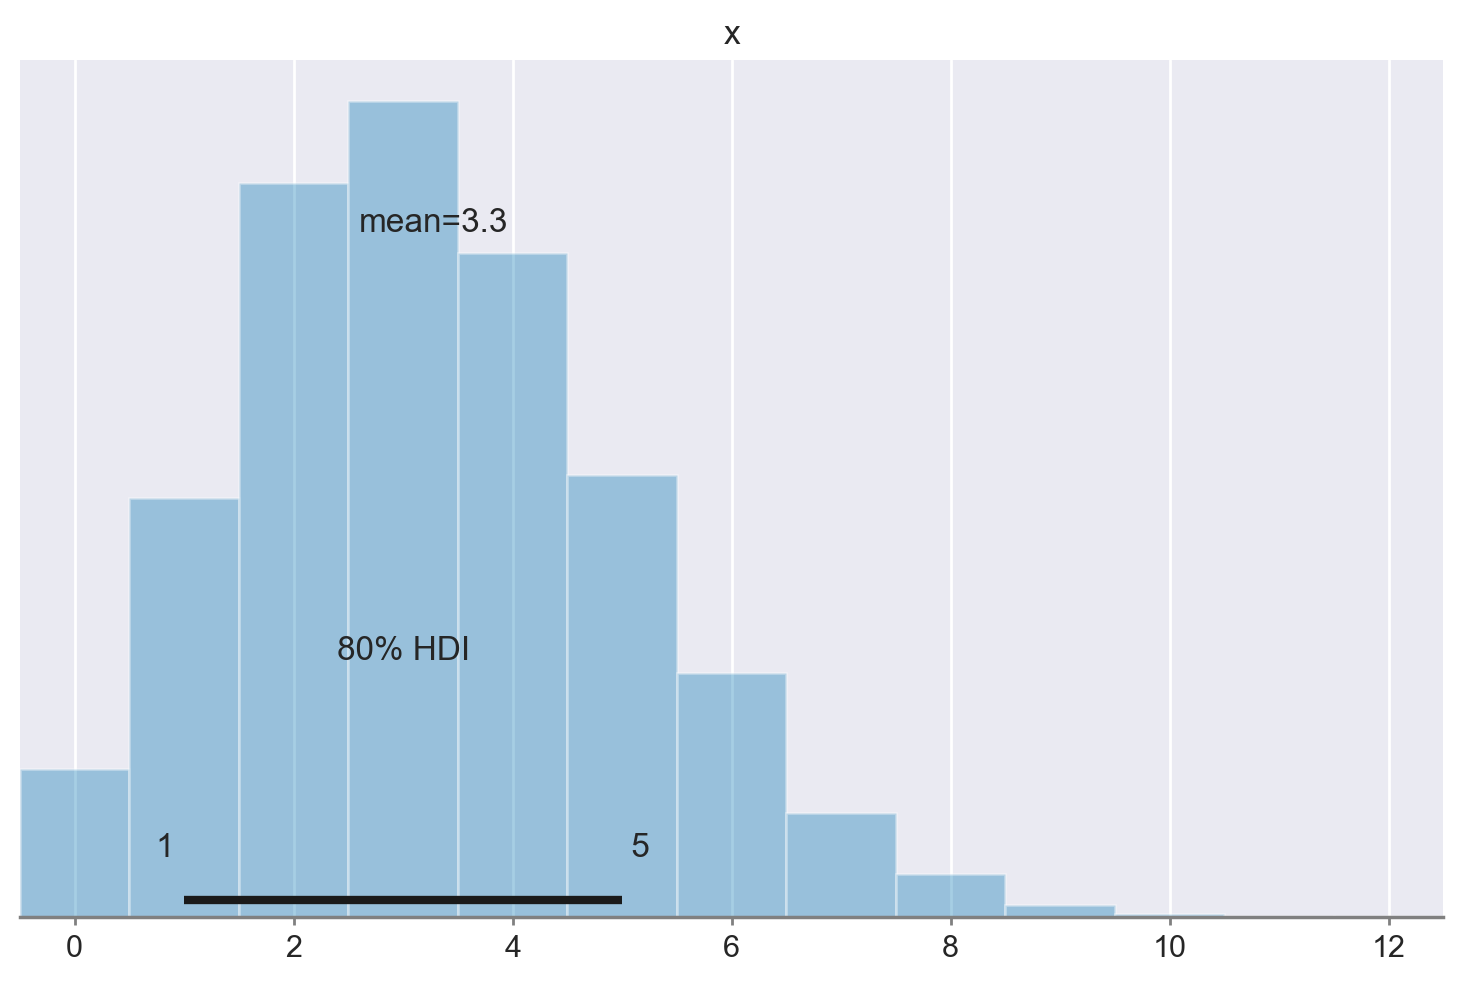

In [18]:
az.plot_posterior(y_rep, hdi_prob=0.8, kind="kde", bw=0.5)
plt.show()

In [19]:
print(alpha_prior, beta_prior)

4 6


In [20]:
with model:
    idata_prior_pred = pm.sample_prior_predictive()

Sampling: [obs, theta]


In [21]:
idata_prior_pred

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

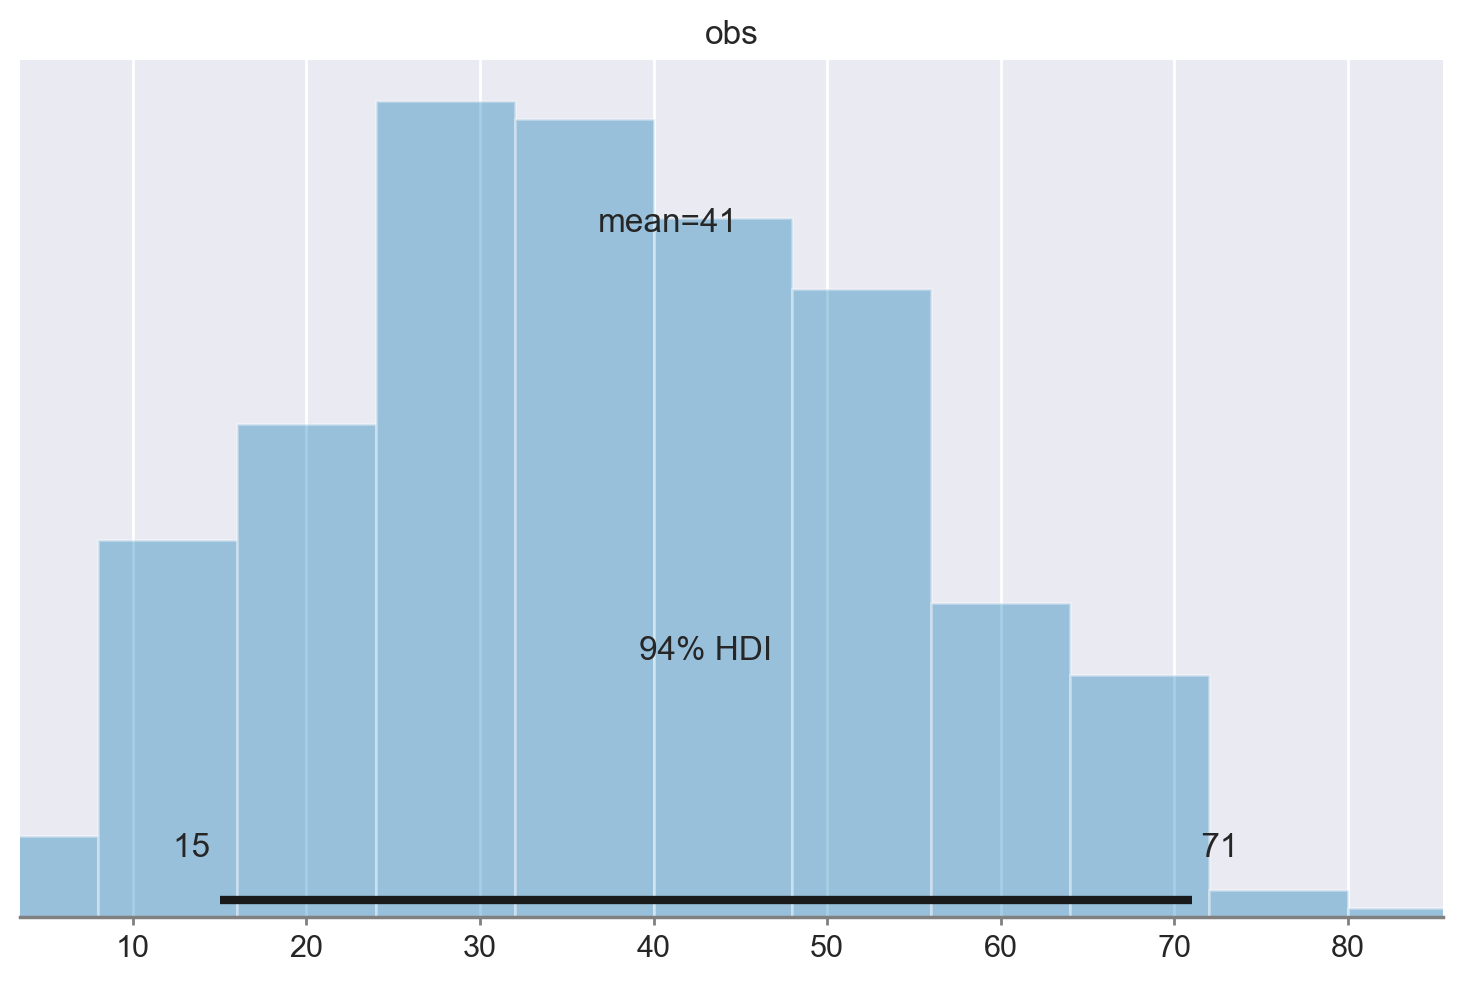

In [22]:
az.plot_posterior(idata_prior_pred.prior_predictive.obs)
plt.show()

In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w 

Last updated: Sat Jan 27 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

numpy     : 1.26.2
pandas    : 2.1.4
seaborn   : 0.13.0
scipy     : 1.11.4
pymc      : 5.10.3
matplotlib: 3.8.2
arviz     : 0.17.0

Watermark: 2.4.3

